In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import pycbc
import sys
sys.path.append('/home/anirudh.nemmani/git_repos/teobresums/Python/') #TEOBResumS module path
import EOBRun_module
sys.path.append('/home/anirudh.nemmani/git_repos/gweat/src/') #GWEAT module path
import TEOBResumS_utils as ecc_gen
import eccentric_source as ecc_sou
from pesummary.io import read

sys.path.append('/home/anirudh.nemmani/git_repos/GWMAT/src/') # GWMAT module path
import py_lgw
lgw = py_lgw.lensed_wf_gen()

In [2]:
# Reading GW150914 parameters

gw150914 = read('../imrct/ground-150914/data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5') # Path to GWTC posterior samples
gw150914_result = gw150914.samples_dict['C01:IMRPhenomXPHM']
gw150914_pe_res = dict()
idx = np.argmax(gw150914_result['log_likelihood'])
for key in gw150914_result.keys():
            val = gw150914_result[key][idx]
            gw150914_pe_res[key] = np.float64(val)

2023-08-23  16:06:16 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2023-08-23  16:06:16 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2023-08-23  16:06:17 PESummary WARNING : Could not find minimum frequency in input file and one was not passed from the command line. Using 20.0Hz as default


In [3]:
# Converting j-frame to l-frame
# Tilts are taken to be zero which is default in GWMAT
spins = lgw.jframe_to_l0frame(gw150914_pe_res['mass_1'], gw150914_pe_res['mass_2'], 20, phi_ref=gw150914_pe_res['phase'], 
                             theta_jn = gw150914_pe_res['theta_jn'], phi_jl=gw150914_pe_res['phi_jl'],
                             a_1=gw150914_pe_res['a_1'], a_2=gw150914_pe_res['a_2'], phi_12 = gw150914_pe_res['phi_12'])

for keys in spins.keys():
    print('%s : %s'%(keys, spins[keys]))

inclination : 2.491015454676615
spin1x : -0.0
spin1y : 0.0
spin1z : 0.8608417198511092
spin2x : -0.0
spin2y : 0.0
spin2z : 0.7195088134379835


# Defining parameters for waveform generation

In [4]:
sampling_frequency = 4096
f_start = 8  # starting frequency of WF, i.e., (2,2) mode of the WF.
f_low = 20    # Lower frequency from where SNR will be computed. It should satisfy the condition, f_start <= f_low, for it to make sense.
f_ref = 20.
f_high = None
# df = 0.007768570860783086 
init_pars = dict(f_start=f_start, f_low=f_low, f_high=f_high, f_ref=f_ref, sample_rate=sampling_frequency, ifo_list=['H1','L1'], wf_approximant='IMRPhenomXP')

cbc_pars = dict(mass_1=gw150914_pe_res['mass_1'], mass_2=gw150914_pe_res['mass_2'], chi1z=spins['spin1z'], chi2z=spins['spin2z'], 
              inclination=spins['inclination'], coa_phase=gw150914_pe_res['phase'], polarization=gw150914_pe_res['psi'], ra=gw150914_pe_res['ra'], dec=gw150914_pe_res['dec'], 
              luminosity_distance=gw150914_pe_res['luminosity_distance'], trigger_time=gw150914_pe_res['geocent_time'],
              ecc=0.2)
#psd_pars = dict(Noise=False, gen_seed=10, psd_L1='O4')
prms = {**init_pars, **cbc_pars}#, **psd_pars
pars = ecc_gen.teobresums_pars_update(prms)

# Generating non-eccentric waveform using the approximant IMRPhenomXP, to have it as a basline

In [5]:
non_eccentric = lgw.lensed_pure_polarized_wf_gen(**pars)

non_eccentric_t_hp = non_eccentric['unlensed_TD_WF_hp']
non_eccentric_t_hc = non_eccentric['unlensed_TD_WF_hc']

non_eccentric_f_hp = non_eccentric['unlensed_FD_WF_hp']
non_eccentric_f_hc = non_eccentric['unlensed_FD_WF_hc']

In [6]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(non_eccentric_t_hp.sample_times, non_eccentric_t_hp, label=r'$h_{+}$')
sub_figure_1.plot(non_eccentric_t_hc.sample_times, non_eccentric_t_hc, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(non_eccentric_f_hp.sample_frequencies, np.abs(non_eccentric_f_hp), label=r'$h_{+}$')
sub_figure_2.loglog(non_eccentric_f_hc.sample_frequencies, np.abs(non_eccentric_f_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(non_eccentric_f_hp.sample_frequencies, np.angle(non_eccentric_f_hp), label=r'$h_{+}$')
sub_figure_3.plot(non_eccentric_f_hc.sample_frequencies, np.angle(non_eccentric_f_hc), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXP')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 non-eccentric waveform IMRPhenomXP')

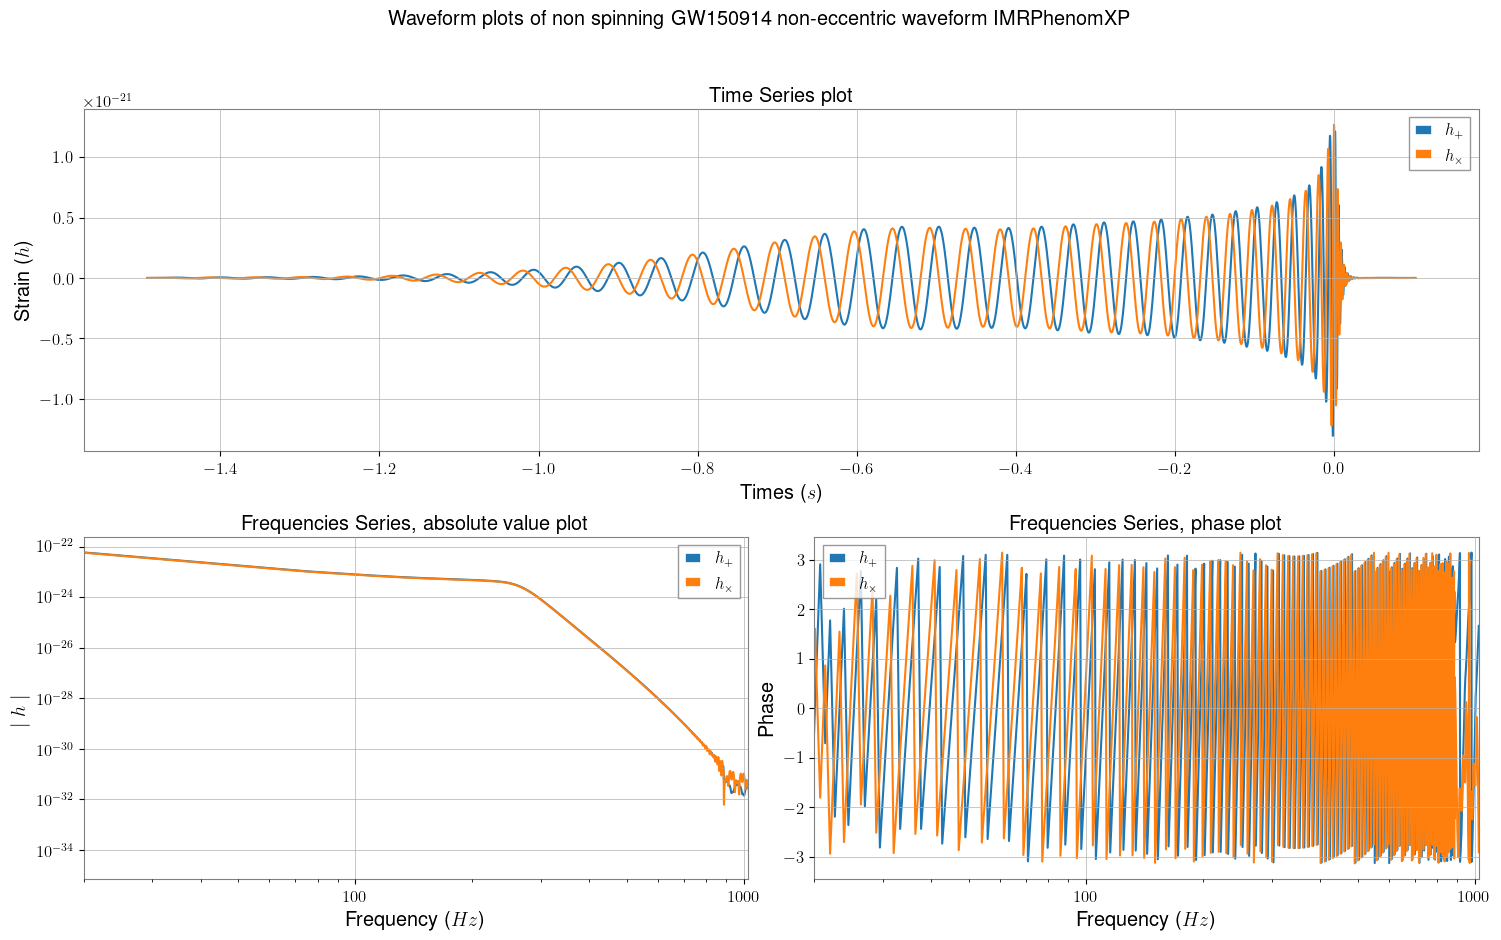

In [7]:
plt.show()

# Generating eccentric pure polarized waveforms using TEOBResumS

In [8]:
t, hp, hc = EOBRun_module.EOBRunPy(pars)

dt = t[1] - t[0]
t_hp = pycbc.types.TimeSeries(hp, delta_t=dt)
t_hc = pycbc.types.TimeSeries(hc, delta_t=dt)

f_hp_e = t_hp.to_frequencyseries(delta_f=t_hp.delta_f)
f_hc_e = t_hc.to_frequencyseries(delta_f=t_hc.delta_f)

In [9]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(t_hp.sample_times, t_hp, label=r'$h_{+}$')
sub_figure_1.plot(t_hc.sample_times, t_hc, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(f_hp_e.sample_frequencies, np.abs(f_hp_e), label=r'$h_{+}$')
sub_figure_2.loglog(f_hc_e.sample_frequencies, np.abs(f_hc_e), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(f_hp_e.sample_frequencies, np.angle(f_hp_e), label=r'$h_{+}$')
sub_figure_3.plot(f_hc_e.sample_frequencies, np.angle(f_hc_e), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

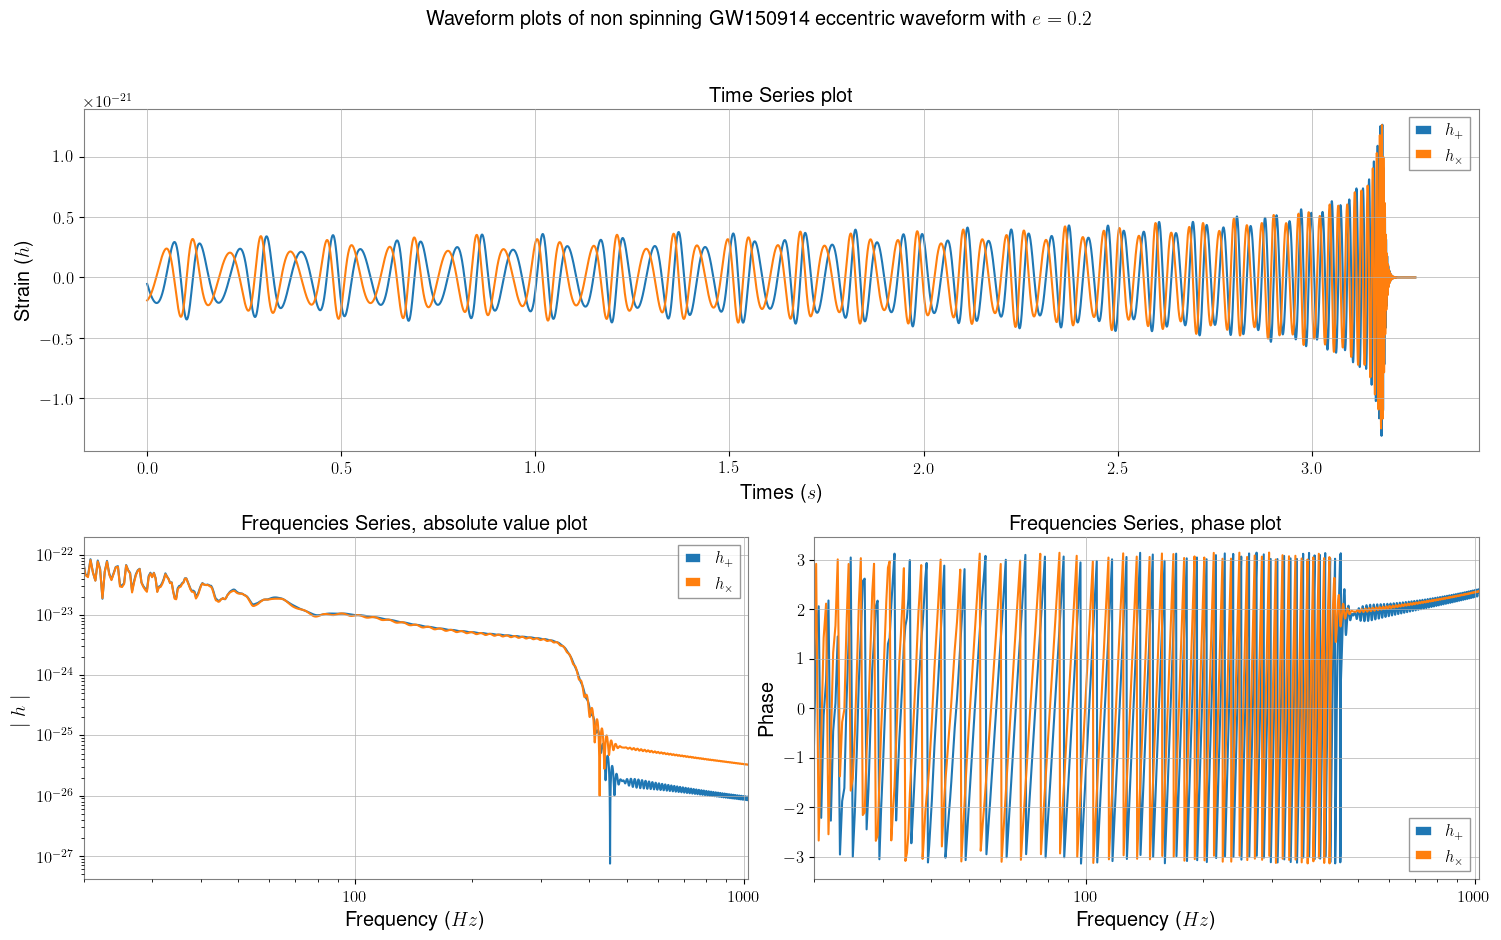

In [10]:
plt.show()

<font size="5">As we can notice here, there's tapering issue. Let's taper it using PyCBC function</font>

In [11]:
t_hp_t = pycbc.waveform.utils.taper_timeseries(t_hp, tapermethod='TAPER_STARTEND', return_lal=False)
t_hc_t = pycbc.waveform.utils.taper_timeseries(t_hc, tapermethod='TAPER_STARTEND', return_lal=False)

f_hp_t = t_hp_t.to_frequencyseries(delta_f=t_hp_t.delta_f)
f_hc_t = t_hc_t.to_frequencyseries(delta_f=t_hc_t.delta_f)

In [12]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(t_hp_t.sample_times, t_hp_t, label=r'$h_{+}$')
sub_figure_1.plot(t_hc_t.sample_times, t_hc_t, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(f_hp_t.sample_frequencies, np.abs(f_hp_t), label=r'$h_{+}$')
sub_figure_2.loglog(f_hc_t.sample_frequencies, np.abs(f_hc_t), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(f_hp_t.sample_frequencies, np.angle(f_hp_t), label=r'$h_{+}$')
sub_figure_3.plot(f_hc_t.sample_frequencies, np.angle(f_hc_t), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

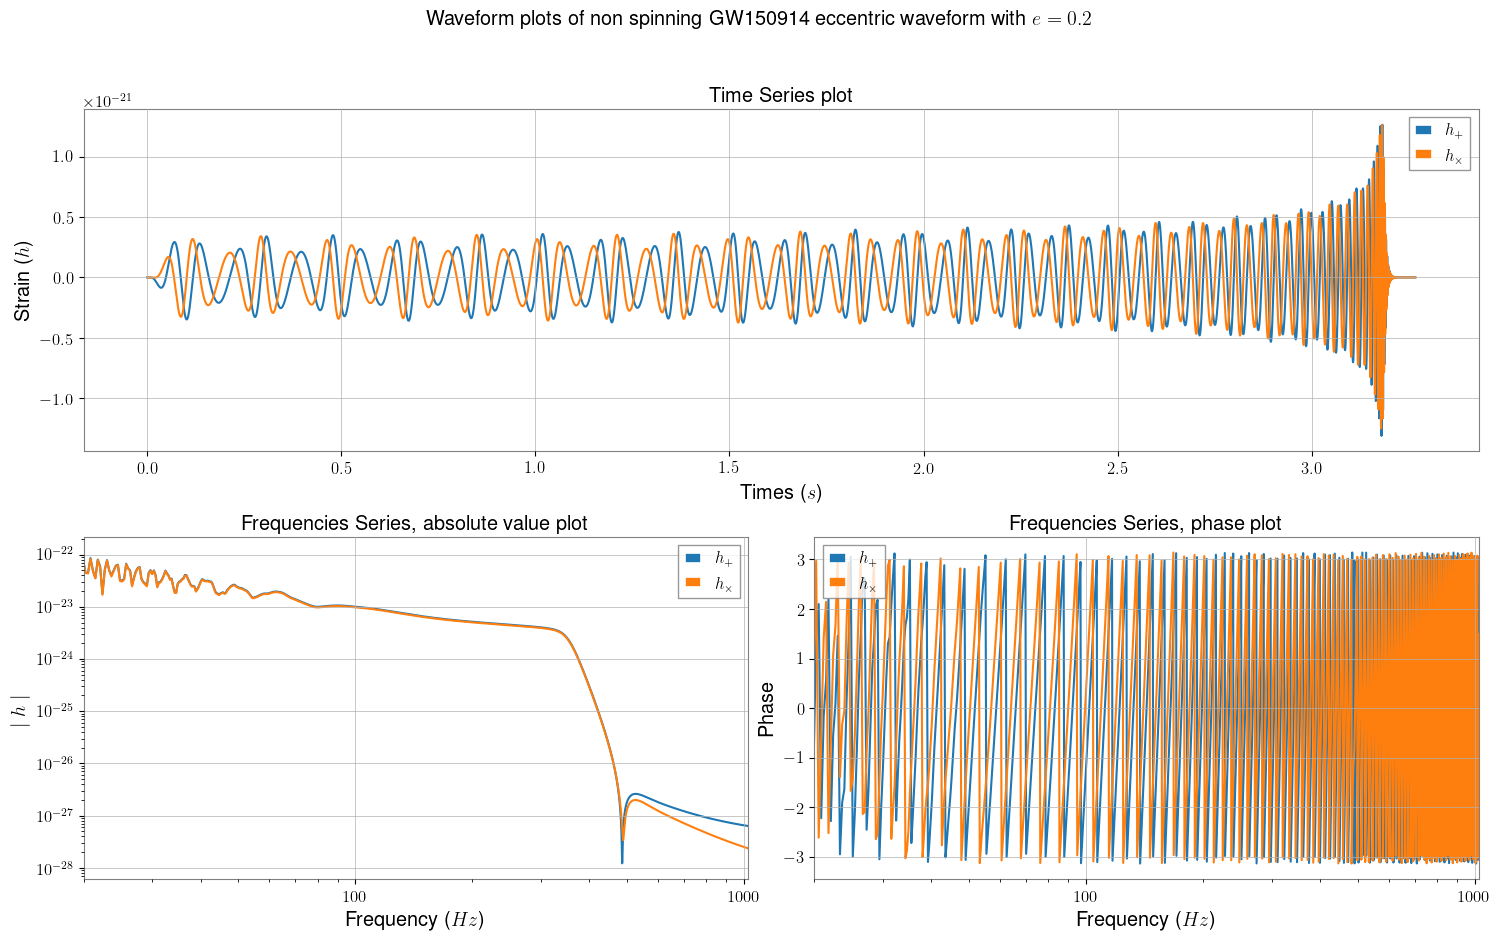

In [13]:
plt.show()

# Generating pure polarized waveforms using GWEAT

In [14]:
wfs_res = ecc_gen.sim_ecc_noisy_wf_gen_with_snr(**pars)

t_hp_e = wfs_res['pure_polarized_wfs']['hp']
t_hc_e = wfs_res['pure_polarized_wfs']['hc']

f_hp = t_hp_e.to_frequencyseries(delta_f=t_hp_e.delta_f)
f_hc = t_hc_e.to_frequencyseries(delta_f=t_hc_e.delta_f)

In [15]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(t_hp_e.sample_times, t_hp_e, label=r'$h_{+}$')
sub_figure_1.plot(t_hc_e.sample_times, t_hc_e, label=r'$h_{\times}$')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(f_hp.sample_frequencies, np.abs(f_hp), label=r'$h_{+}$')
sub_figure_2.loglog(f_hc.sample_frequencies, np.abs(f_hc), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(f_hp.sample_frequencies, np.angle(f_hp), label=r'$h_{+}$')
sub_figure_3.plot(f_hc.sample_frequencies, np.angle(f_hc), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

Text(0.5, 0.98, 'Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

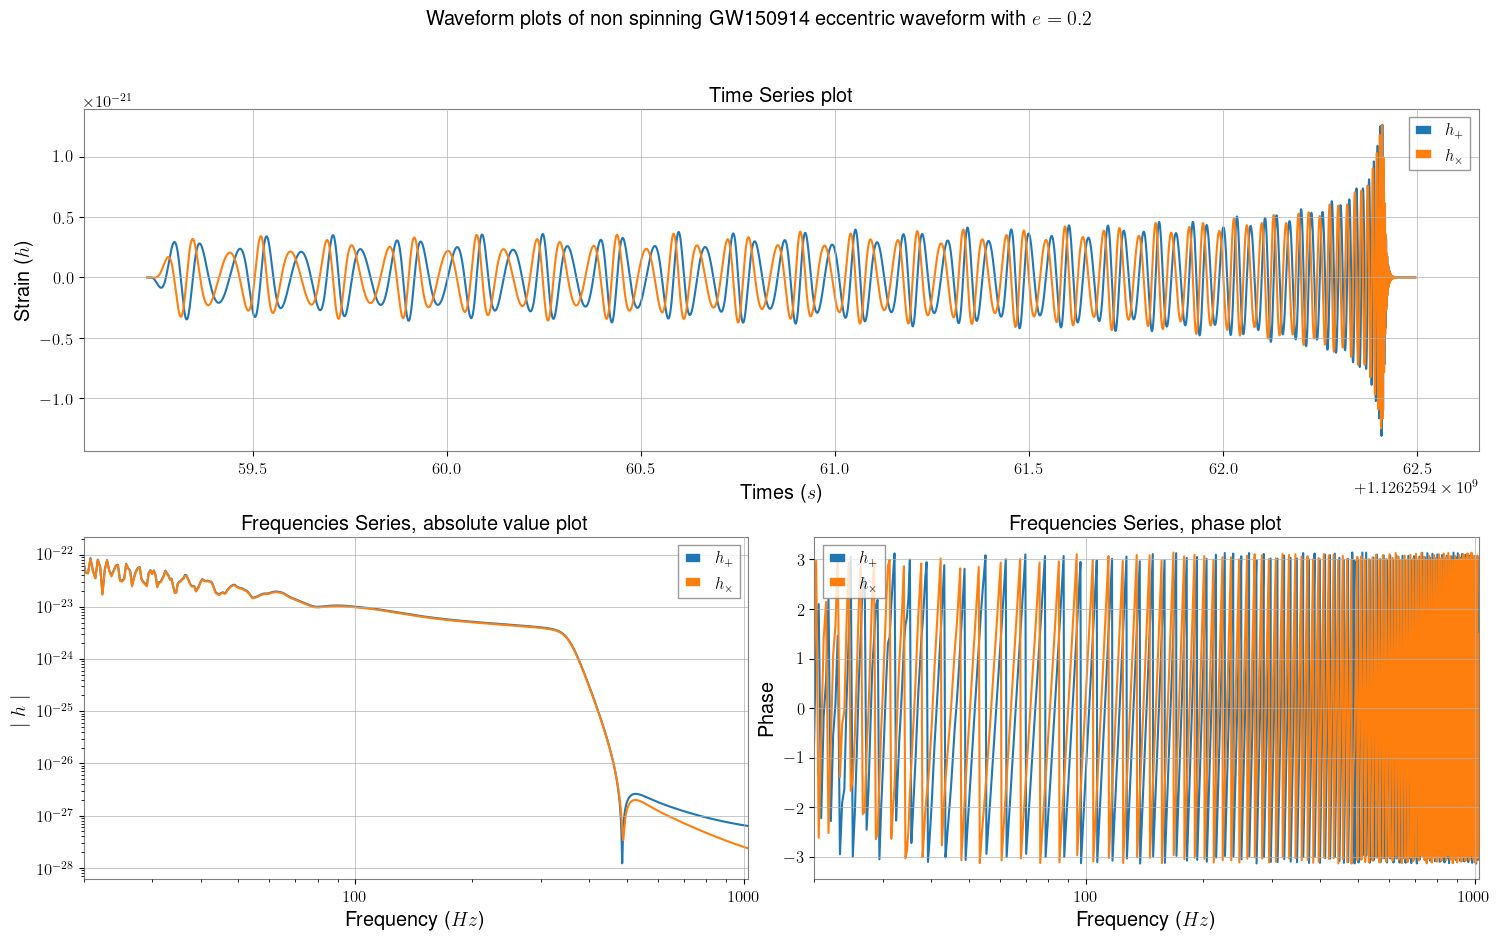

In [16]:
plt.show()

<font size="5">Let's check if the waveforms we have generated using pure TEOBResumS and GWEAT as same using PyCBC match function</font>

In [17]:
length = max(len(t_hp_e), len(t_hp_t))
t_hp_e.resize(length)
t_hp_t.resize(length)
psd = pycbc.psd.from_txt('/home/anirudh.nemmani/Projects/imrct/ground-150914/data/psd/psd_aLIGO_O4high.txt', length, t_hp_e.delta_f, f_low, is_asd_file=False)
match_hp = pycbc.filter.match(t_hp_e, t_hp_t, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=None)

length = max(len(t_hc_e), len(t_hc_t))
t_hc_e.resize(length)
t_hc_t.resize(length)
psd = pycbc.psd.from_txt('/home/anirudh.nemmani/Projects/imrct/ground-150914/data/psd/psd_aLIGO_O4high.txt', length, t_hc_e.delta_f, f_low, is_asd_file=False)
match_hc = pycbc.filter.match(t_hc_e, t_hc_t, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=None)

print('Match between the plus polarized waveforms generated using TEOBResumS and GWEAT : %s'%(round(match_hp[0], 3)))
print('Match between the cross polarized waveforms generated using TEOBResumS and GWEAT : %s'%(round(match_hc[0], 3)))

Match between the plus polarized waveforms generated using TEOBResumS and GWEAT : 1.0
Match between the cross polarized waveforms generated using TEOBResumS and GWEAT : 1.0


# Projecting the frequency series wavefroms using the antenna pattern functions from PyCBC

In [18]:
# Importing Antenna Pattern Functions
from pycbc.detector import Detector

fp_l1, fc_l1 = Detector('L1').antenna_pattern(gw150914_pe_res['ra'], gw150914_pe_res['dec'], gw150914_pe_res['psi'], gw150914_pe_res['geocent_time'])
fp_h1, fc_h1 = Detector('H1').antenna_pattern(gw150914_pe_res['ra'], gw150914_pe_res['dec'], gw150914_pe_res['psi'], gw150914_pe_res['geocent_time'])

In [19]:
# Projecting the pure polarized waveform

# LIGO LIVINGSTON Projection
hp_project_l1 = fp_l1*f_hp
hc_project_l1 = fc_l1*f_hc
tot_project_l1 = hp_project_l1 + hc_project_l1

# LIGO HANFORD Projection
hp_project_h1 = fp_h1*f_hp
hc_project_h1 = fc_h1*f_hc
tot_project_h1 = hp_project_h1 + hc_project_h1

In [20]:
fig = plt.figure(figsize=(18, 10))
# plt.subplots_adjust(wspace= 0.1, hspace= 0.25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

sub_figure_1 = fig.add_subplot(2,3,1)
sub_figure_1.loglog(f_hp.sample_frequencies, np.abs(hp_project_l1), label=r'L1')
sub_figure_1.loglog(f_hp.sample_frequencies, np.abs(hp_project_h1), label=r'H1')
sub_figure_1.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_1.set_xlabel(r'Frequency ($Hz$)')
sub_figure_1.set_xlim(20, 1024)
sub_figure_1.set_ylabel(r'$\mid h \mid$')
sub_figure_1.legend()
# sub_figure_1.text(x = 0, y = 0, s = r'\textbf{Absolute value plots}', rotation=90)

sub_figure_2 = fig.add_subplot(2,3,2)
sub_figure_2.loglog(f_hc.sample_frequencies, np.abs(hc_project_l1), label=r'L1')
sub_figure_2.loglog(f_hc.sample_frequencies, np.abs(hc_project_h1), label=r'H1')
sub_figure_2.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
# sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,3,3)
sub_figure_3.loglog(f_hp.sample_frequencies, np.abs(tot_project_l1), label=r'L1')
sub_figure_3.loglog(f_hp.sample_frequencies, np.abs(tot_project_h1), label=r'H1')
sub_figure_3.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xlim(20, 1024)
# sub_figure_3.set_ylabel(r'$\mid h \mid$')
sub_figure_3.legend()

sub_figure_4 = fig.add_subplot(2,3,4)
sub_figure_4.plot(f_hp.sample_frequencies, np.angle(hp_project_l1), label=r'L1')
sub_figure_4.plot(f_hp.sample_frequencies, np.angle(hp_project_h1), label=r'H1')
sub_figure_4.set_title(r'Plus Projection, $F_{+}h_{+}$')
sub_figure_4.set_xlabel(r'Frequency ($Hz$)')
sub_figure_4.set_xscale('log')
sub_figure_4.set_xlim(20, 1024)
sub_figure_4.set_ylabel(r'Phase')
sub_figure_4.legend()
# sub_figure_4.text(x = 0, y = 0, s = r'\textbf{Phase value plots}', rotation=90)

sub_figure_5 = fig.add_subplot(2,3,5)
sub_figure_5.plot(f_hc.sample_frequencies, np.angle(hc_project_l1), label=r'L1')
sub_figure_5.plot(f_hc.sample_frequencies, np.angle(hc_project_h1), label=r'H1')
sub_figure_5.set_title(r'Cross Projection, $F_{\times}h_{\times}$')
sub_figure_5.set_xlabel(r'Frequency ($Hz$)')
sub_figure_5.set_xscale('log')
sub_figure_5.set_xlim(20, 1024)
# sub_figure_5.set_ylabel(r'Phase')
sub_figure_5.legend()

sub_figure_6 = fig.add_subplot(2,3,6)
sub_figure_6.plot(f_hp.sample_frequencies, np.angle(tot_project_l1), label=r'L1')
sub_figure_6.plot(f_hp.sample_frequencies, np.angle(tot_project_h1), label=r'H1')
sub_figure_6.set_title(r'Total Projection, $F_{+}h_{+} + F_{\times}h_{\times}$')
sub_figure_6.set_xlabel(r'Frequency ($Hz$)')
sub_figure_6.set_xscale('log')
sub_figure_6.set_xlim(20, 1024)
# sub_figure_6.set_ylabel(r'Phase')
sub_figure_6.legend()

plt.suptitle(r'Projection plots of non spinning GW150914 eccentric waveform with $e = 0.2$')
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

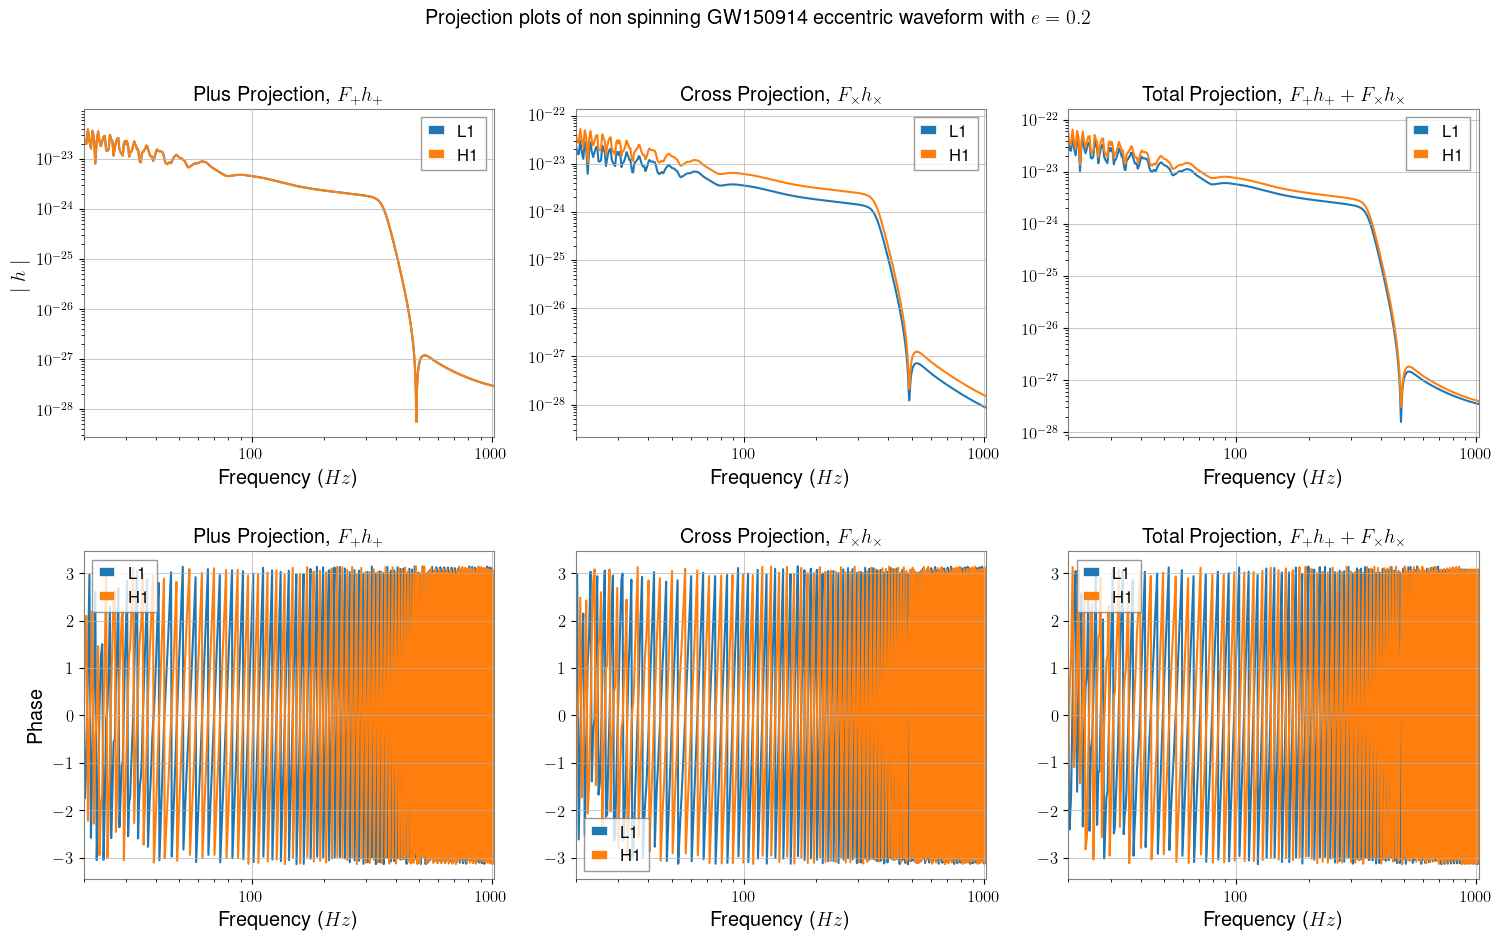

In [21]:
plt.show()

# Projecting the time series projected wavefroms using project_wave from PyCBC and then converting into frequency series

In [22]:
time_projected = ecc_gen.sim_ecc_wf_gen(**pars)

In [23]:
# Converting into frequency series
time_projected_fl1 = time_projected['pure_ifo_signal']['L1'].to_frequencyseries(delta_f=time_projected['pure_ifo_signal']['L1'].delta_f)
time_projected_fh1 = time_projected['pure_ifo_signal']['H1'].to_frequencyseries(delta_f=time_projected['pure_ifo_signal']['H1'].delta_f)

In [24]:
fig = plt.figure(figsize=(18, 10))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)


sub_figure_1 = fig.add_subplot(2,2,(1, 2)) # two rows, two columns, first and second cell
sub_figure_1.plot(time_projected['pure_ifo_signal']['L1'].sample_times, time_projected['pure_ifo_signal']['L1'], label=r'L1')
sub_figure_1.plot(time_projected['pure_ifo_signal']['H1'].sample_times, time_projected['pure_ifo_signal']['H1'], label=r'H1')
sub_figure_1.set_title(r'Time Series plot')
sub_figure_1.set_xlabel(r'Times ($s$)')
sub_figure_1.set_ylabel(r'Strain ($h$)')
sub_figure_1.legend()

sub_figure_2 = fig.add_subplot(2,2,3) # two rows, two columns, third cell
sub_figure_2.loglog(time_projected_fl1.sample_frequencies, np.abs(time_projected_fl1), label=r'L1')
sub_figure_2.loglog(time_projected_fh1.sample_frequencies, np.abs(time_projected_fh1), label=r'H1')
sub_figure_2.set_title(r'Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(2,2,4) # two rows, two columns, fourth cell
sub_figure_3.plot(time_projected_fl1.sample_frequencies, np.angle(time_projected_fl1), label=r'L1')
sub_figure_3.plot(time_projected_fh1.sample_frequencies, np.angle(time_projected_fh1), label=r'H1')
sub_figure_3.set_title(r'Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Time projected waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

Text(0.5, 0.98, 'Time projected waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

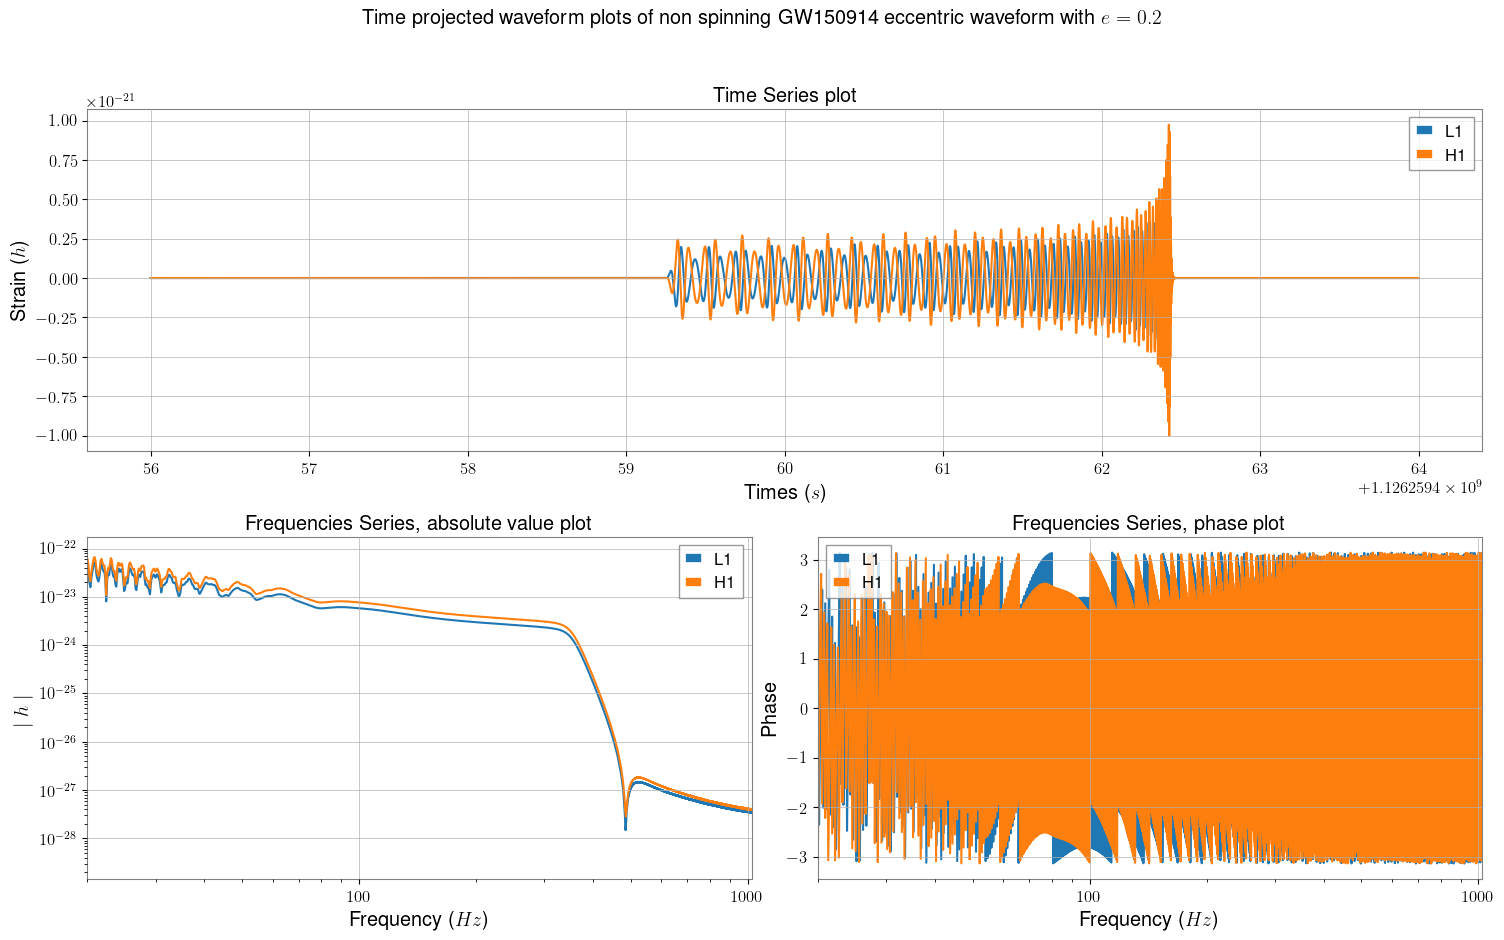

In [25]:
plt.show()

# So what exactly is going wrong? Am I an idiot to spend an week to have no issue?
# Let's see, hope I am

# Projecting an waveform which is interpolated into a specific frequency vector

In [26]:
# The frequency vector is the frequency vector of the PSD (This was chosen since GWFish was using it)
frequency_vector = np.loadtxt('frequency_vector.txt')

In [27]:
# Interpolating using GWEAT
interpolated = ecc_sou.eccentric_TEOBResumS_BBH_FD(frequency_vector, **pars)


###### {'M': 68.75498279849768, 'q': 1.1510187511248808, 'LambdaAl2': 0.0, 'LambdaBl2': 0.0, 'chi1': 0.8608417198511092, 'chi2': 0.7195088134379835, 'chi1x': 0.0, 'chi1y': 0.0, 'chi1z': 0.8608417198511092, 'chi2x': 0.0, 'chi2y': 0.0, 'chi2z': 0.7195088134379835, 'distance': 509.14230092272595, 'inclination': 2.491015454676615, 'coalescence_angle': 4.000226339478637, 'domain': 0, 'initial_frequency': 8, 'use_mode_lm': [1], 'use_geometric_units': 0, 'srate_interp': 4096, 'interp_uniform_grid': 1, 'df': 0.01, 'srate': 4096, 'output_lm': [1], 'output_dynamics': 0, 'output_ringdown': 0, 'output_dir': './data/', 'arg_out': 0, 'ecc': 0.2, 'ecc_freq': 2, 'f_start': 8, 'sample_rate': 4096, 'delta_t': 0.000244140625, 'mode_array': None, 'lambda1': 0.0, 'lambda2': 0.0, 'trigger_time': 1126259462.408404, 'taper': True, 'f_low': 20, 'f_high': None, 'f_ref': 20.0, 'ifo_list': ['H1', 'L1'], 'wf_approximant': 'IMRPhenomXP', 'mass_1': 36.79106674126104, 'mass_2': 31.96391605723664, 'coa_phase': 4.0002

In [28]:
# Plotting Interpolated waveform
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace= 0.1, hspace= 0.25)

sub_figure_2 = fig.add_subplot(1,2,1)
sub_figure_2.loglog(frequency_vector, np.abs(interpolated['plus']), label=r'$h_{+}$')
sub_figure_2.loglog(frequency_vector, np.abs(interpolated['cross']), label=r'$h_{\times}$')
sub_figure_2.set_title(r'Interpolated Frequencies Series, absolute value plot')
sub_figure_2.set_xlabel(r'Frequency ($Hz$)')
sub_figure_2.set_xlim(20, 1024)
sub_figure_2.set_ylabel(r'$\mid h \mid$')
sub_figure_2.legend()

sub_figure_3 = fig.add_subplot(1,2,2)
sub_figure_3.plot(frequency_vector, np.angle(interpolated['plus']), label=r'$h_{+}$')
sub_figure_3.plot(frequency_vector, np.angle(interpolated['cross']), label=r'$h_{\times}$')
sub_figure_3.set_title(r'Interpolated Frequencies Series, phase plot')
sub_figure_3.set_xlabel(r'Frequency ($Hz$)')
sub_figure_3.set_xscale('log')
sub_figure_3.set_xlim(20, 1024)
sub_figure_3.set_ylabel(r'Phase')
sub_figure_3.legend()

plt.suptitle(r'Interpolated Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

Text(0.5, 0.98, 'Interpolated Waveform plots of non spinning GW150914 eccentric waveform with $e = 0.2$')

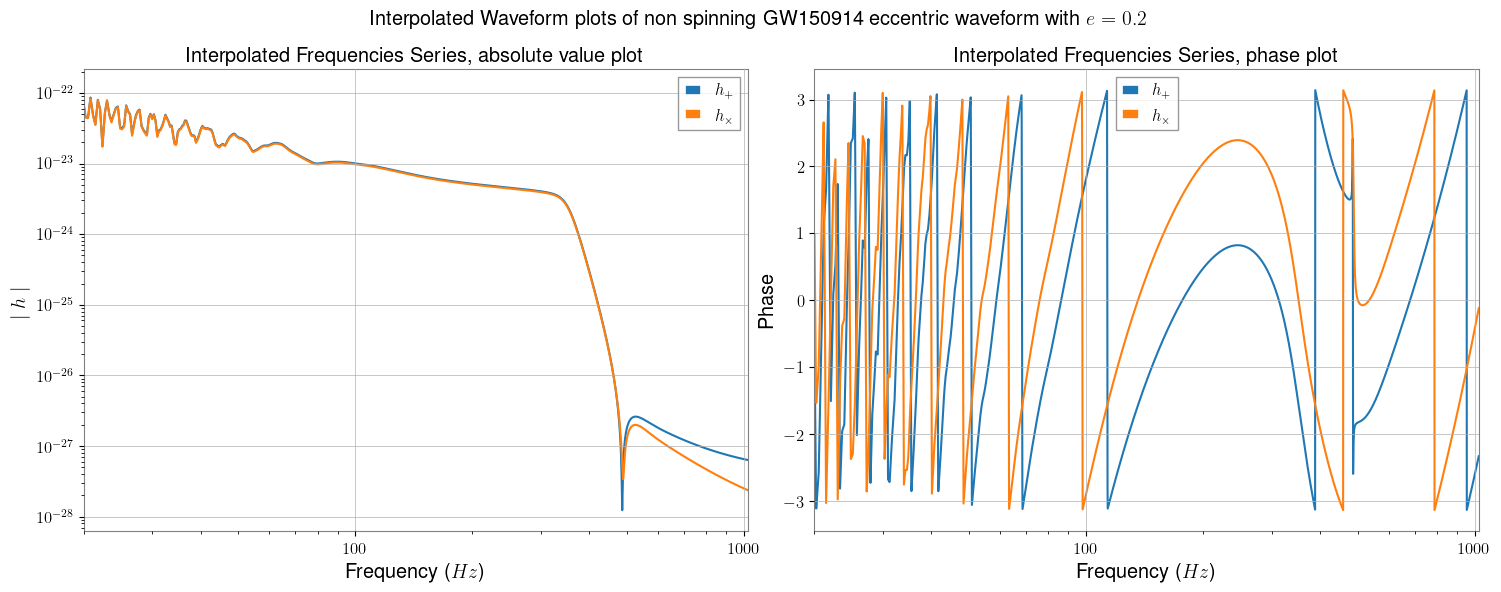

In [29]:
plt.show()